Import Necessary Modules

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder

Initialize Variables

In [2]:
number_train_images = 60000
number_test_images = 10000
total_pixels=784
column_names=['labels'] + [f'pixel{i}' for i in range(total_pixels)]

Create Paths for Data

In [3]:
def getPath(relative_path):
    # Create a Path object with the relative path and resolve it to an absolute path
    return str(Path.cwd().joinpath(relative_path).resolve())

In [4]:
mnist_train_ubyte_images = getPath("data/train-images-idx3-ubyte")
mnist_train_ubyte_labels = getPath("data/train-labels-idx1-ubyte")
mnist_test_ubyte_images = getPath("data/t10k-images-idx3-ubyte")
mnist_test_ubyte_labels = getPath("data/t10k-labels-idx1-ubyte")
train_csv_path = getPath("mnist_csv/mnist_train.csv")
test_csv_path = getPath("mnist_csv/mnist_test.csv")

Convert Data to CSV

In [5]:
def mnist_to_csv(imgs, labels, csvPath, n, total_pixels):
    # Read image and label dat
    imgData = open(imgs, 'rb')
    labelData = open(labels, 'rb')
    # Write CSV file
    csvData = open(csvPath, 'w')

    # Skip header information and write to images array
    imgData.read(16)
    labelData.read(8)
    images = []

    # Loop through n and append pixel data to images array
    for i in range(n):
        # Capture label in image array and loop through total pixels count to add corresponding data to image
        image = [ord(labelData.read(1))]
        for j in range(total_pixels):
            image.append(ord(imgData.read(1)))
        # Append image list to images list
        images.append(image)

    # Write image data to CSV file by iterating through image array and separating row data by comma
    for image in images:
        csvData.write(','.join(str(pix) for pix in image) + '\n')

    # Close files
    imgData.close()
    labelData.close()
    csvData.close()

In [6]:
mnist_to_csv(mnist_train_ubyte_images, mnist_train_ubyte_labels, train_csv_path, number_train_images, total_pixels)
mnist_to_csv(mnist_test_ubyte_images, mnist_test_ubyte_labels, test_csv_path, number_test_images, total_pixels)

In [7]:
df_train = pd.read_csv(train_csv_path, header=None, names=column_names)
df_test = pd.read_csv(test_csv_path, header=None, names=column_names)

Create a NeuralNetwork Class

In [24]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation_functions, learning_rate=0.01):
        self.input_size = input_size # First Layer Size (784 for 28x28 pixel images)
        self.hidden_layers = hidden_layers # Array with Hidden Layers Sizes
        self.output_size = output_size # Last Layer Size (10 for each digit in MNIST)
        self.activation_functions = activation_functions # Array of Activation Functions for each layer
        self.learning_rate = learning_rate # Learning Rate
        self.layers = [self.input_size] + hidden_layers + [self.output_size] # Array Containing the Size of Each Layer
        self.weights = self.initialize_weights() # Initialize weights
        self.biases = self.initialize_biases() # Initializa bias
        self.loss_history = [] # Save loss for plotting
        self.accuracy_history = [] # Save accuracy for plotting

    def initialize_weights(self):
        # Simple Random Weights:
        #   Create an array of 2D arrays of size Layer1 x Layer 2 for the sake of matrix multiplication
        #   Weight Initialization Sizes Reference: https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/
        return [np.random.randn(self.layers[i+1], self.layers[i]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        

    def initialize_biases(self):
        # Bias:
        #   Create a array of arrays of size Layer2 x 1
        return [np.zeros((self.layers[i+1], 1)) for i in range(len(self.layers)-1)]

    def forward_propagation(self, weights, biases, x, a_t=None, count=0):
        # Forward Propagation:
        #   Iterate through list of weights and biases through recursion
        #   Base Case: When count has reached the length of the weights array there is no more data to apply forward propagation
        #   In each iteration apply the formula wT*x+b to get z and apply the activation function specified for that layer
        
        if a_t is None:
            a_t = [x]
    
        if count == len(weights):
            return x, a_t
    
        z = np.dot(weights[count], x) + biases[count]
        print(f"Layer {count}: z mean = {np.mean(z)}, z min = {np.min(z)}, z max = {np.max(z)}")  # Debugging
        a_t.append(self.activation_functions[count](z))
        return self.forward_propagation(weights, biases, a_t[-1], a_t, count+1)
    
    @staticmethod
    def relu(z):
        # ReLU function
        return np.maximum(0, z)
    
    @staticmethod
    def sigmoid(z):
        # Sigmoid function
        return 1/(1+np.exp(-z))
    
    @staticmethod
    def tanh(z):
        # Hyperbolic tan function
        return (np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z))
    
    @staticmethod
    def softmax(z):
        # Softmax function
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    
    def activation_derivative(self, activation, function):
        # Derivative of activation functions
        if function == self.sigmoid or function.__name__ == 'sigmoid':
            return activation * (1 - activation)
        elif function == self.relu or function.__name__ == 'relu':
            return np.where(activation > 0, 1, 0)
        elif function == self.tanh or function.__name__ == 'tanh':
            return 1 - activation**2
        elif function == self.softmax or function.__name__ == 'softmax':
            return np.ones_like(activation)
        else:
            raise ValueError("Unknown activation function")


    def backward_propagation(self, y_true, activations, weights, biases):
        # Backwanrds Propagation:
        #   Initialize weights/bias gradient lists
        #   Calculate error delta of the last layer
        #   Iterate backwards through the weights and biases and apply the formulas to determine the gradients
        #   Update weights using formula w=w-n*dL/dw or b=b-n*dL/db

        weight_grads = [None]*len(weights)
        bias_grads = [None]*len(biases)
        delta = activations[-1] - y_true
    
        for i in reversed(range(len(weights))):
            weight_grads[i] = np.dot(delta, activations[i].T)
            bias_grads[i] = np.sum(delta, axis=1, keepdims=True)
        
            if i != 0:
                delta = np.dot(weights[i].T, delta) * self.activation_derivative(activations[i], self.activation_functions[i])

        for i in range(len(weights)):
            weights[i] -= self.learning_rate * weight_grads[i]
            biases[i] -= self.learning_rate * bias_grads[i]

        return weights, biases
    

    def compute_loss(self, y_true, y_pred):
        # Cross-Entropy Loss
        # Added extremely small number to avoid taking log(0)
        m = y_true.shape[1]
        epsilon = 1e-8  # Small value to prevent log(0)
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        return loss

    def train(self, x_train, y_train, x=None, y=None, epochs=10):
        # Training:
        #   Loop through each epoch
        #   Forward propagate and calculate loss
        #   Backwards propagate 
        for epoch in range(epochs):
            y_pred, activations = self.forward_propagation(self.weights, self.biases, x_train)
            loss = self.compute_loss(y_train, y_pred)
            self.loss_history.append(loss)
            
            if x is not None and y is not None:
                y_val_pred, _ = self.forward_propagation(self.weights, self.biases, x)
                val_accuracy = self.accuracy(y, y_val_pred)
                self.accuracy_history.append(val_accuracy)
            
            self.weights, self.biases = self.backward_propagation(y_train, activations, self.weights, self.biases)
            
            if epoch % 10 == 0:
                if x is not None and y is not None:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
                else:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}')

    def predict(self, x):
        # Predict method to use the network
        y_pred, _ = self.forward_propagation(self.weights, self.biases, x)
        return np.argmax(y_pred, axis=0)

    def accuracy(self, y_true, y_pred):
        # Accuracy calculation
        predictions = np.argmax(y_pred, axis=0)
        return np.mean(predictions == y_true)
    
    def plot_metrics(self):
        # Plotting the loss curve
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        if self.accuracy_history:
            plt.subplot(1, 2, 2)
            plt.plot(self.accuracy_history, label='Validation Accuracy', color='orange')
            plt.title('Validation Accuracy over epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
        
        plt.show()

Epoch 0, Loss: 16.3802


c:\Users\ambhp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Epoch 10, Loss: nan
Epoch 20, Loss: nan
Epoch 30, Loss: nan
Epoch 40, Loss: nan
Epoch 50, Loss: nan
Epoch 60, Loss: nan
Epoch 70, Loss: nan
Epoch 80, Loss: nan
Epoch 90, Loss: nan
Test Accuracy: 0.0980


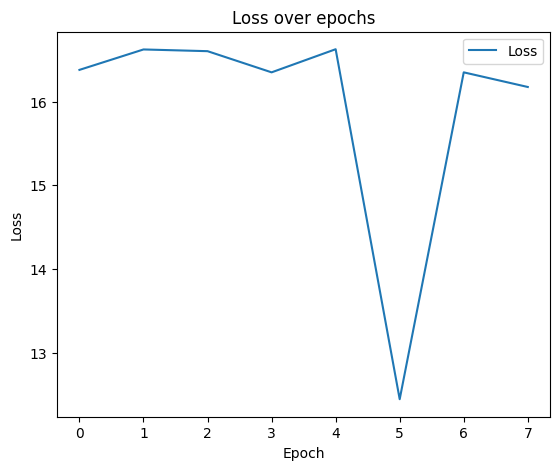

In [25]:
# Assuming your data frames are named train_df and test_df

# Separate features and labels
x_train = df_train.drop('labels', axis=1).values  # Drop the 'label' column
y_train = df_train['labels'].values  # Extract the 'label' column

x_test = df_test.drop('labels', axis=1).values
y_test = df_test['labels'].values

# Normalize the pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Transpose the data to match the input format expected by the neural network
x_train = x_train.T
x_test = x_test.T

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).T
y_test = encoder.transform(y_test.reshape(-1, 1)).T

# Initialize the neural network
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10,
                   activation_functions=[NeuralNetwork.relu, NeuralNetwork.relu, NeuralNetwork.softmax], learning_rate=0.01)

# Train the network
nn.train(x_train, y_train, epochs=100)

# Predict on test data
y_pred_test = nn.predict(x_test)

# Evaluate accuracy
accuracy = nn.accuracy(np.argmax(y_test, axis=0), y_pred_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot the training metrics
nn.plot_metrics()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation_functions, learning_rate=0.001):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.activation_functions = activation_functions
        self.learning_rate = learning_rate
        self.layers = [self.input_size] + hidden_layers + [self.output_size]
        self.weights = self.initialize_weights()
        self.biases = self.initialize_biases()
        self.loss_history = []
        self.accuracy_history = []

    def initialize_weights(self):
        # Xavier/Glorot initialization for better convergence with ReLU
        return [np.random.randn(self.layers[i+1], self.layers[i]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]

    def initialize_biases(self):
        return [np.zeros((self.layers[i+1], 1)) for i in range(len(self.layers)-1)]

    def forward_propagation(self, weights, biases, x, a_t=None, count=0):
        if a_t is None:
            a_t = [x]
        
        if count == len(weights):
            return x, a_t
        
        z = np.dot(weights[count], x) + biases[count]
        print(f"Layer {count}: z mean = {np.mean(z)}, z min = {np.min(z)}, z max = {np.max(z)}")  # Debugging
        a_t.append(self.activation_functions[count](z))
        return self.forward_propagation(weights, biases, a_t[-1], a_t, count + 1)

    @staticmethod
    def relu(z):
        return np.maximum(0, z)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def tanh(z):
        return np.tanh(z)
    
    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def activation_derivative(self, activation, function):
        if function == self.sigmoid or function.__name__ == 'sigmoid':
            return activation * (1 - activation)
        elif function == self.relu or function.__name__ == 'relu':
            return np.where(activation > 0, 1, 0)
        elif function == self.tanh or function.__name__ == 'tanh':
            return 1 - activation**2
        elif function == self.softmax or function.__name__ == 'softmax':
            return np.ones_like(activation)
        else:
            raise ValueError("Unknown activation function")

    def backward_propagation(self, y_true, activations, weights, biases):
        weight_grads = [None]*len(weights)
        bias_grads = [None]*len(biases)
        delta = activations[-1] - y_true
    
        for i in reversed(range(len(weights))):
            weight_grads[i] = np.dot(delta, activations[i].T)
            bias_grads[i] = np.sum(delta, axis=1, keepdims=True)
        
            if i != 0:
                delta = np.dot(weights[i].T, delta) * self.activation_derivative(activations[i], self.activation_functions[i])

        for i in range(len(weights)):
            weights[i] -= self.learning_rate * weight_grads[i]
            biases[i] -= self.learning_rate * bias_grads[i]

        return weights, biases
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        epsilon = 1e-8  # Small value to prevent log(0)
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        return loss

    def train(self, x_train, y_train, x=None, y=None, epochs=100):
        for epoch in range(epochs):
            y_pred, activations = self.forward_propagation(self.weights, self.biases, x_train)
            loss = self.compute_loss(y_train, y_pred)
            self.loss_history.append(loss)
            
            if x is not None and y is not None:
                y_val_pred, _ = self.forward_propagation(self.weights, self.biases, x)
                val_accuracy = self.accuracy(y, y_val_pred)
                self.accuracy_history.append(val_accuracy)
            
            self.weights, self.biases = self.backward_propagation(y_train, activations, self.weights, self.biases)
            
            if epoch % 10 == 0:
                if x is not None and y is not None:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
                else:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}')

    def predict(self, x):
        y_pred, _ = self.forward_propagation(self.weights, self.biases, x)
        return np.argmax(y_pred, axis=0)

    def accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=0)
        return np.mean(predictions == y_true)
    
    def plot_metrics(self):
        plt.figure(figsize=(14, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        if self.accuracy_history:
            plt.subplot(1, 2, 2)
            plt.plot(self.accuracy_history, label='Validation Accuracy', color='orange')
            plt.title('Validation Accuracy over epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
        
        plt.show()


Layer 0: z mean = -0.01323080862855092, z min = -2.7651540196598674, z max = 3.2562857433043977
Layer 1: z mean = 0.06349483267876534, z min = -2.6843426448741936, z max = 2.8383907516073386
Layer 2: z mean = 0.06810965911639492, z min = -2.0137843813051237, z max = 2.269166415045391
Epoch 0, Loss: 2.3497
Layer 0: z mean = -3.099778548752066, z min = -207.88191680020992, z max = 245.55021304983327
Layer 1: z mean = -110.55114163770655, z min = -2834.264399009079, z max = 2860.1600560338566
Layer 2: z mean = 61.745107726513076, z min = -12355.065540387073, z max = 6705.64631356008
Layer 0: z mean = 2208.7445664111665, z min = -9087.072706084555, z max = 69019.58612014593
Layer 1: z mean = -296349330.4029404, z min = -4876588895.402296, z max = 432106079.99338484
Layer 2: z mean = 23034391.761193335, z min = -3453043215873.507, z max = 667369016059.744
Layer 0: z mean = 18755166898.687534, z min = -194755334.93248028, z max = 530202481662.03925
Layer 1: z mean = -7.652941665685137e+20, z

c:\Users\ambhp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Layer 0: z mean = 5.616960804757864e+235, z min = -1184494580029788.8, z max = 1.6154517362045074e+237
Layer 1: z mean = nan, z min = -inf, z max = inf
Layer 2: z mean = nan, z min = -inf, z max = inf


c:\Users\ambhp\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\ambhp\AppData\Local\Temp\ipykernel_39272\2190761670.py:51: RuntimeWarning: invalid value encountered in subtract
  exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))


Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = nan, z min = nan, z max = nan
Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = nan, z min = nan, z max = nan
Epoch 10, Loss: nan
Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = nan, z min = nan, z max = nan
Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = nan, z min = nan, z max = nan
Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = nan, z min = nan, z max = nan
Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = nan, z min = nan, z max = nan
Layer 0: z mean = nan, z min = nan, z max = nan
Layer 1: z mean = nan, z min = nan, z max = nan
Layer 2: z mean = na

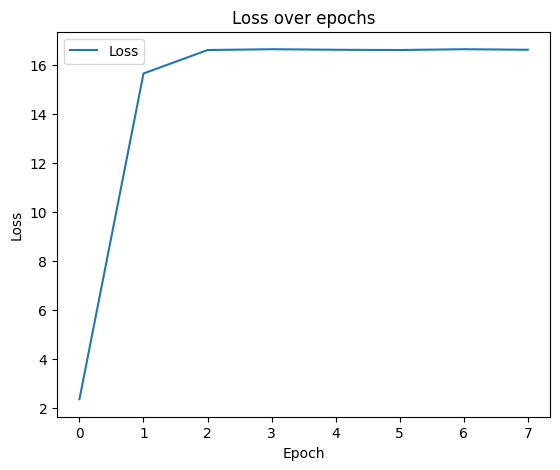

In [27]:
# Assuming your data frames are named train_df and test_df

# Separate features and labels
x_train = df_train.drop('labels', axis=1).values  # Drop the 'label' column
y_train = df_train['labels'].values  # Extract the 'label' column

x_test = df_test.drop('labels', axis=1).values
y_test = df_test['labels'].values

# Normalize the pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Transpose the data to match the input format expected by the neural network
x_train = x_train.T
x_test = x_test.T

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).T
y_test = encoder.transform(y_test.reshape(-1, 1)).T

# Initialize the neural network
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10,
                   activation_functions=[NeuralNetwork.relu, NeuralNetwork.relu, NeuralNetwork.softmax],
                   learning_rate=0.001)

# Train the network
nn.train(x_train, y_train, epochs=100)

# Predict on test data
y_pred_test = nn.predict(x_test)

# Evaluate accuracy
accuracy = nn.accuracy(np.argmax(y_test, axis=0), y_pred_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot the training metrics
nn.plot_metrics()


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation_functions, learning_rate=0.0001):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.activation_functions = activation_functions
        self.learning_rate = learning_rate
        self.layers = [self.input_size] + hidden_layers + [self.output_size]
        self.weights = self.initialize_weights()
        self.biases = self.initialize_biases()
        self.loss_history = []
        self.accuracy_history = []

    def initialize_weights(self):
        return [np.random.randn(self.layers[i+1], self.layers[i]) * np.sqrt(1. / self.layers[i]) for i in range(len(self.layers)-1)]

    def initialize_biases(self):
        return [np.zeros((self.layers[i+1], 1)) for i in range(len(self.layers)-1)]

    def forward_propagation(self, weights, biases, x, a_t=None, count=0):
        if a_t is None:
            a_t = [x]
        
        if count == len(weights):
            return x, a_t
        
        z = np.dot(weights[count], x) + biases[count]
        print(f"Layer {count}: z mean = {np.mean(z)}, z min = {np.min(z)}, z max = {np.max(z)}")
        a_t.append(self.activation_functions[count](z))
        return self.forward_propagation(weights, biases, a_t[-1], a_t, count + 1)

    @staticmethod
    def leaky_relu(z, alpha=0.01):
        return np.where(z > 0, z, alpha * z)

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def tanh(z):
        return np.tanh(z)
    
    @staticmethod
    def softmax(z):
        exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def activation_derivative(self, activation, function):
        if function == self.sigmoid or function.__name__ == 'sigmoid':
            return activation * (1 - activation)
        elif function == self.leaky_relu or function.__name__ == 'leaky_relu':
            return np.where(activation > 0, 1, 0.01)
        elif function == self.tanh or function.__name__ == 'tanh':
            return 1 - activation**2
        elif function == self.softmax or function.__name__ == 'softmax':
            return np.ones_like(activation)
        else:
            raise ValueError("Unknown activation function")

    def backward_propagation(self, y_true, activations, weights, biases):
        weight_grads = [None]*len(weights)
        bias_grads = [None]*len(biases)
        delta = activations[-1] - y_true

        for i in reversed(range(len(weights))):
            weight_grads[i] = np.dot(delta, activations[i].T)
            bias_grads[i] = np.sum(delta, axis=1, keepdims=True)

            # Apply gradient clipping
            weight_grads[i] = np.clip(weight_grads[i], -1, 1)
            bias_grads[i] = np.clip(bias_grads[i], -1, 1)
        
            if i != 0:
                delta = np.dot(weights[i].T, delta) * self.activation_derivative(activations[i], self.activation_functions[i])

        for i in range(len(weights)):
            weights[i] -= self.learning_rate * weight_grads[i]
            biases[i] -= self.learning_rate * bias_grads[i]

        return weights, biases
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[1]
        epsilon = 1e-8  # Small value to prevent log(0)
        loss = -np.sum(y_true * np.log(y_pred + epsilon)) / m
        return loss

    def train(self, x_train, y_train, x=None, y=None, epochs=100):
        for epoch in range(epochs):
            y_pred, activations = self.forward_propagation(self.weights, self.biases, x_train)
            loss = self.compute_loss(y_train, y_pred)
            self.loss_history.append(loss)

            # Calculate accuracy
            train_accuracy = self.accuracy(np.argmax(y_train, axis=0), np.argmax(y_pred, axis=0))
            self.accuracy_history.append(train_accuracy)
        
            if x is not None and y is not None:
                y_val_pred, _ = self.forward_propagation(self.weights, self.biases, x)
                val_accuracy = self.accuracy(y, y_val_pred)
                self.accuracy_history.append(val_accuracy)
        
            self.weights, self.biases = self.backward_propagation(y_train, activations, self.weights, self.biases)
        
            if epoch % 10 == 0:
                if x is not None and y is not None:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')
                else:
                    print(f'Epoch {epoch}, Loss: {loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    def predict(self, x):
        y_pred, _ = self.forward_propagation(self.weights, self.biases, x)
        return np.argmax(y_pred, axis=0)

    def accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=0)
        return np.mean(predictions == y_true)
    
    def plot_metrics(self):
        plt.figure(figsize=(14, 7))
    
        # Plot Loss
        plt.subplot(2, 1, 1)
        plt.plot(self.loss_history, label='Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
    
        # Plot Accuracy
        plt.subplot(2, 1, 2)
        plt.plot(self.accuracy_history, label='Training Accuracy', color='green')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
    
        plt.tight_layout()
        plt.show()

Layer 0: z mean = -0.003951439610272015, z min = -1.971076251571942, z max = 1.5782822397049967
Layer 1: z mean = 0.053482682421406996, z min = -1.2408854286900473, z max = 1.4850472759684739
Layer 2: z mean = 0.06366930760299178, z min = -1.0576342682920963, z max = 1.0994135627685675
Epoch 0, Loss: 2.3118, Training Accuracy: 0.0987
Layer 0: z mean = -0.004456199290273096, z min = -1.9770416477615635, z max = 1.5740002637099275
Layer 1: z mean = 0.05269743366184571, z min = -1.2381915830947892, z max = 1.481133073328161
Layer 2: z mean = 0.06274140686972451, z min = -1.0360596250631906, z max = 1.0834798879078407
Layer 0: z mean = -0.004818363898875528, z min = -1.9829139091312942, z max = 1.5869748305789686
Layer 1: z mean = 0.05194216936065402, z min = -1.2429146761353418, z max = 1.478018493548727
Layer 2: z mean = 0.06187452371015654, z min = -1.0143313554496254, z max = 1.0682079568684522
Layer 0: z mean = -0.005019103192601456, z min = -1.9883640834538467, z max = 1.603120036654

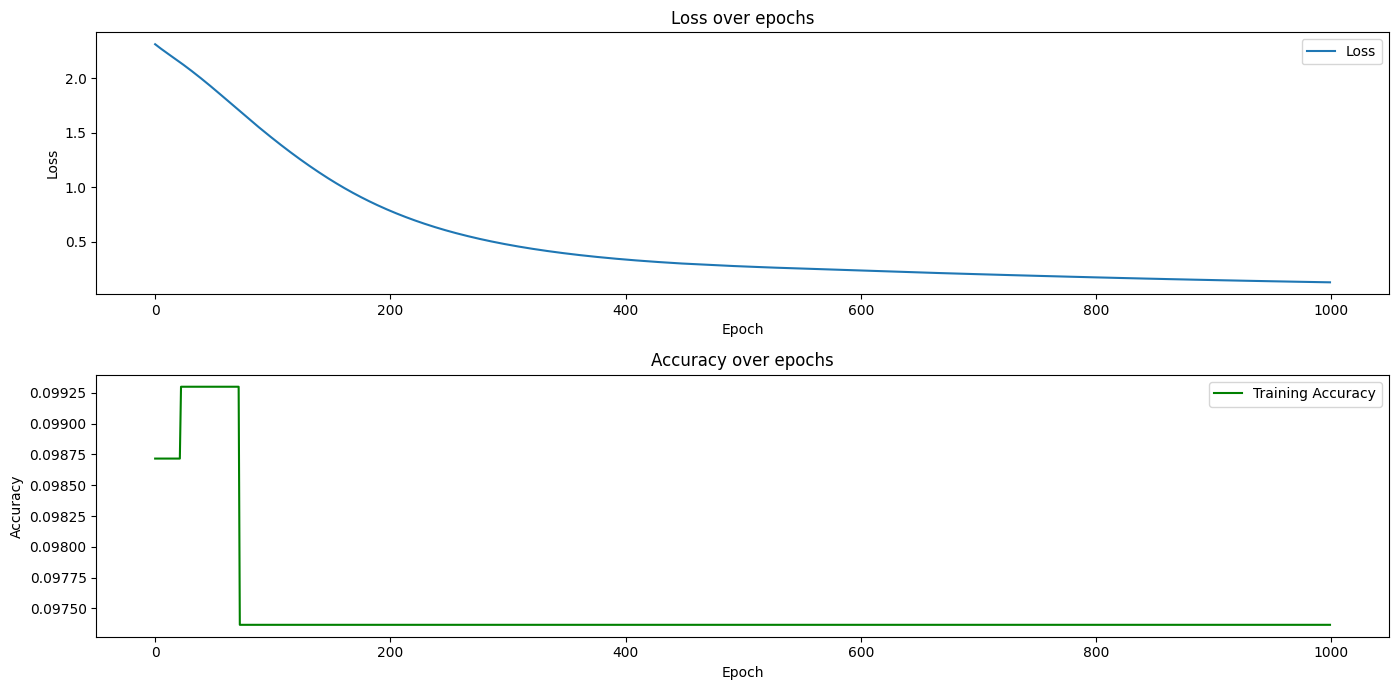

In [33]:
# Assuming your data frames are named train_df and test_df

# Separate features and labels
x_train = df_train.drop('labels', axis=1).values  # Drop the 'label' column
y_train = df_train['labels'].values  # Extract the 'label' column

x_test = df_test.drop('labels', axis=1).values
y_test = df_test['labels'].values

# Normalize the pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Transpose the data to match the input format expected by the neural network
x_train = x_train.T
x_test = x_test.T

# One-hot encode the labels
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).T
y_test = encoder.transform(y_test.reshape(-1, 1)).T

# Initialize the neural network with the Leaky ReLU activation function and a lower learning rate
nn = NeuralNetwork(input_size=784, hidden_layers=[128, 64], output_size=10,
                   activation_functions=[NeuralNetwork.leaky_relu, NeuralNetwork.leaky_relu, NeuralNetwork.softmax],
                   learning_rate=0.0001)

# Train the network
nn.train(x_train, y_train, epochs=1000)

# Predict on test data
y_pred_test = nn.predict(x_test)

# Evaluate accuracy
accuracy = nn.accuracy(np.argmax(y_test, axis=0), y_pred_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot the training metrics
nn.plot_metrics()
